# Function definition (they will be used starting from the "execution" cell)

# Load data

In [1]:
import numpy as np
import os
from os import listdir
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img


def load_images(path,train_size):
    src_list, tar_list = [], []
    for num, filename in enumerate(listdir(path)):
        #Load the image
        pixels = load_img(os.path.join(path, filename))
        #Convert to numpy array
        pixels = img_to_array(pixels)
        #Split into source and target images
        real_img, seg_img = pixels[:, :256], pixels[:, 256:]  #seg=segmented
        src_list.append(real_img)
        tar_list.append(seg_img)
        #Stop loading when "train_size" is reached
        if num==(train_size-1):
            break

    return [np.asarray(src_list), np.asarray(tar_list)]

# Encoder block

In [2]:
#The model for the generator is based on an encoder-decoder architecture (see under its cell).
#The encoder block is defined here

from tensorflow import keras
from keras.layers import Conv2D
from keras.initializers import RandomNormal
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

def define_encoder_block(layer_in, n_filters, batchnorm=True): 
    #Randomly intialize the weights (using normal distribution)
    init = RandomNormal(stddev=0.02,seed=0)  
    #Convolution layer (and size reduction 2-fold)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    #Conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    #Leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# Decoder block

In [3]:
#The model for the generator is based on an encoder-decoder architecture (see under its cell).
#The decoder block is defined here.

from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import Activation

def decoder_block(layer_in, skip_in, n_filters, dropout=True): 

    #Weight initialization
    init = RandomNormal(stddev=0.02,seed=0)   
    #Size increment 2-fold (by convolution transpose)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    #Add batch normalization
    g = BatchNormalization()(g, training=True)
    #Conditionally add Dropout
    if dropout:
        g = Dropout(0.3)(g, training=True)
    #Merge with skip connection
    g = Concatenate()([g, skip_in])  
    #Relu activation
    g = Activation('relu')(g)
    return g

# Model for the generator

In [4]:
#The model is based on the U-Net architecture 

from keras import Input
from keras.models import Model

def define_generator(image_shape=(256,256,3)):
    #Weight initialization
    init = RandomNormal(stddev=0.02,seed=0)
    #Image input
    in_image = Input(shape=image_shape)
    
    #Encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False) 
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)  #output size 2x2
    
    #Bottleneck block (the last encoder block), no batch normlization and relu activation
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    
    #Decoder model
    d1 = decoder_block(b, e7, 512)  #connects layers d1 and e7 ("skips" b) both with output size 2x2. 
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False) 
    
    #Output (3 filters (for RGB), tanh acitivation for range [-1,1] (normalized image), and output size 256x256)
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)  
    out_image = Activation('tanh')(g) 
    
    #Define model
    model = Model(in_image, out_image)
    return model
 

# Model for the discriminator

In [5]:
from keras.optimizers import Adam


def define_discriminator(image_shape):
    
    #Weight initialization
    init = RandomNormal(stddev=0.02,seed=0)
    #Source image input
    in_src_image = Input(shape=image_shape)  
    #Target image input
    in_target_image = Input(shape=image_shape)
    #Concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
 
    #First convolution layer (and size reduction 2-fold)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged) 
    d = LeakyReLU(alpha=0.2)(d) # No batch normalization in the first layer
    #Second convolution layer (and size reduction 2-fold)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    #Third convolution layer (and size reduction 2-fold)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    #4th convolution layer (and size reduction 2-fold)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    #Second last output layer (No size reduction. Final size is 16x16 which is the patch size)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    #Patch (final) output (one filter for the binary classification and sigmoid activation)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    #Define model
    model = Model([in_src_image, in_target_image], patch_out)  
    #Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5]) #Weight the loss with 0.5
    return model
 

# The GAN model (that combines the discriminator and the generator)

In [6]:
def define_gan(g_model, d_model, image_shape):
    #Make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization): 
            layer.trainable = False

    #Define the source image
    in_src = Input(shape=image_shape)
    #Use the source image as input to the generator
    gen_out = g_model(in_src) 
    #Feed the source image and the generator output to the discriminator
    dis_out = d_model([in_src, gen_out])
    #Define source image as input, generated image and classification as outputs
    model = Model(in_src, [dis_out, gen_out])
    #Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    #Use 'loss_weights' for stronger effect of the generator loss (L1 loss) over the discriminator loss (cross entropy)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100]) 
    
    return model

# Get a batch of real images and label them

In [7]:
from numpy.random import randint

def generate_real_samples(dataset, n_samples, patch_shape):
    #Load data
    trainA, trainB = dataset
    #Generate random selection of samples
    ix = randint(0, trainA.shape[0], n_samples)
    #Retrieve the selected images
    X1, X2 = trainA[ix], trainB[ix]
    #Label images with 1 (real)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# Generate fake images and label them

In [8]:
def generate_fake_samples(g_model, samples, patch_shape):
    #Generate fake images
    X = g_model.predict(samples)
    #Label images with 0 (fake)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# Get information from training

In [9]:
#This saves plots and the model (h5 file) at a certain step of the training

import matplotlib.pyplot as plt

def summarize_performance(step, g_model, dataset, n_samples=3):
    #Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1) 
    #Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    #Scale pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    #Plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    #Plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    #Plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples * 2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    #Save plot to file
    dir='C:/Research/GAN/models/cityscape/plots'
    filename1 = 'plot_%06d.png' % (step + 1)
    plt.savefig(os.path.join(dir,filename1))
    plt.close()
    #Save the generator model
    dir2='C:/Research/GAN/models/cityscape/models'
    filename2 = 'model_%06d.h5' % (step + 1)
    g_model.save(os.path.join(dir2,filename2))
    print('>Saved: %s and %s' % (filename1, filename2))

# Training

In [10]:
#Trainging is done with batch size ('n_batch') of 1

def train(d_model, g_model, gan_model, dataset, n_epochs=70, n_batch=1):   
    #Set the patch shape (discriminator output shape)
    n_patch = d_model.output_shape[1]
    #Load data from dataset
    trainA, trainB = dataset
    #Calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    #Calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    #The training iteration 
    for i in range(n_steps):
        #Select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        #Generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        #Update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)   
        #Update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        #Update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        #Print step index and loss values
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1, d_loss1, d_loss2, g_loss))
        #Every 10 epochs plot figs and save the model 
        if (i + 1) % (bat_per_epo * 10) == 0:   
            summarize_performance(i, g_model, dataset)


# Execution

# Load the data

In [11]:
#Dataset path 
path = 'C:/Research/GAN/datasets/cityscapes/train'
#Set training size 
train_size=300     
#Load the data
[src_images, tar_images] = load_images(path,train_size)
print(f' Loaded source images:  {src_images.shape}, target images: {tar_images.shape}')


 Loaded source images:  (300, 256, 256, 3), target images: (300, 256, 256, 3)


# Plot one pair of loaded images

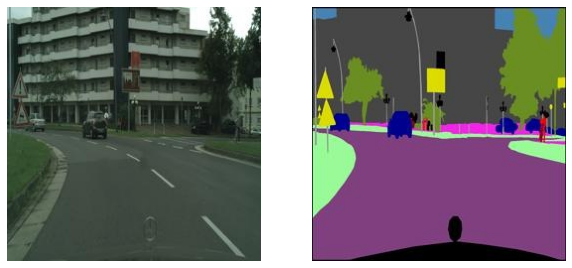

In [13]:
#Set the image to be ploted
image_to_plot=0

#Define the subplot structure
fig,axs=plt.subplots(1,2, figsize=(10,10))
axs=axs.flatten()

#Plot the images ('unit8' shows RGB images from np arrays)
axs[0].imshow(src_images[image_to_plot].astype('uint8'))
axs[1].imshow(tar_images[image_to_plot].astype('uint8')) 
axs[0].set_axis_off()
axs[1].set_axis_off()

#fig.savefig('C:/Research/GAN/for Github/Plots/Example_img_from_dataset.png',bbox_inches='tight')

# Normalize the data

In [14]:
#Normalization into range [-1,1]

#Get the max pixel value
max_pixel_val_src=np.max(src_images)
max_pixel_val_tar=np.max(tar_images)

#Apply the transformation
src_images=(src_images-max_pixel_val_src/2)/(max_pixel_val_src/2)
tar_images=(tar_images-max_pixel_val_tar/2)/(max_pixel_val_tar/2)

#Print range after transformation 
print(f'source image: [{np.min(src_images)},{np.max(src_images)}]') 
print(f'source image: [{np.min(tar_images)},{np.max(tar_images)}]')


source image: [-1.0,1.0]
source image: [-1.0,1.0]


# Initialize models and begin training 

In [15]:
dataset = [src_images, tar_images]    
#Define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
#Define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Train model in the next line which is muted since model was already trained and saved
#train(d_model, g_model, gan_model, dataset)

# Results 

1/1 [==============================] - 1s 950ms/step
test shape:(3, 5, 256, 256, 3)


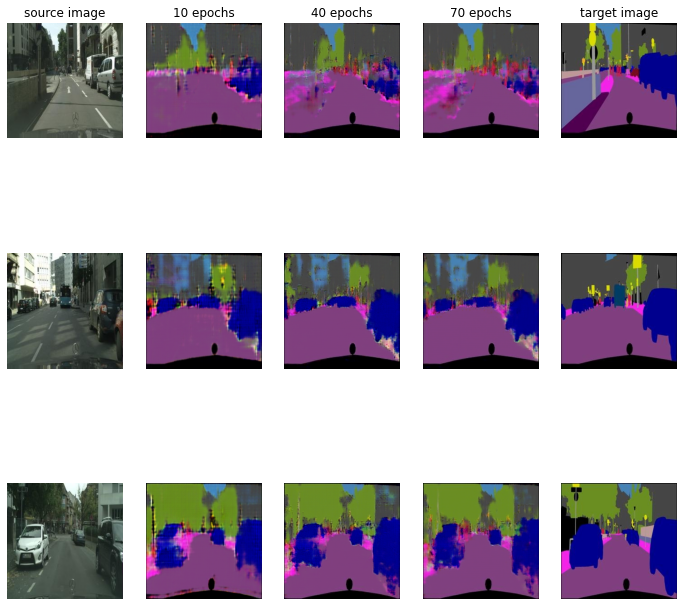

In [16]:
from keras.models import load_model

model_10_epochs = load_model('C:/Research/GAN/models/cityscape/models/model_003000.h5')
model_40_epochs = load_model('C:/Research/GAN/models/cityscape/models/model_012000.h5')
model_70_epochs = load_model('C:/Research/GAN/models/cityscape/models/model_021000.h5')


#Load 300 images from the validation data set 
[val_src_img, val_tar_img] = load_images('C:/Research/GAN/datasets/cityscapes/val',300)


#Choose randomly 3 images (run one time and save)
#ix2 = randint(0, val_src_img.shape[0], 3) 
ix2=[44,256,263]
val_src_img, val_tar_img = val_src_img[ix2], val_tar_img[ix2]


#Normalize images to [-1,1] to load to the model
##Get the max pixel value
max_pixel_val_src=np.max(val_src_img)
max_pixel_val_tar=np.max(val_tar_img)

##Apply the transformation
val_src_img=(val_src_img-max_pixel_val_src/2)/(max_pixel_val_src/2)
val_tar_img=(val_tar_img-max_pixel_val_tar/2)/(max_pixel_val_tar/2)

#Generate predictions using the models
prediction_10_epochs=model_10_epochs.predict(val_src_img)
prediction_40_epochs=model_40_epochs.predict(val_src_img)
prediction_70_epochs=model_70_epochs.predict(val_src_img)


#Create the images for the first row of the plot (first validation image)
images_first_row = np.array([val_src_img[0],prediction_10_epochs[0],prediction_40_epochs[0],
                  prediction_70_epochs[0],val_tar_img[0]])


#Create the images for the second row (second validation image)
images_second_row = np.array([val_src_img[1],prediction_10_epochs[1],prediction_40_epochs[1],
                   prediction_70_epochs[1],val_tar_img[1]])

#Create the images for the third row (third validation image)
images_third_row = np.array([val_src_img[2],prediction_10_epochs[2],prediction_40_epochs[2],
                   prediction_70_epochs[2],val_tar_img[2]])

#Concatenate the images of the three rows and reshape to create an imgae grid of shape (3,5)
image_grid_plot=np.concatenate([images_first_row,images_second_row,images_third_row],axis=0).reshape(3,5,256,256,3)

print(f'test shape:{image_grid_plot.shape}')

#Scale images from [-1,1] to [0,1] for plotting
image_grid_plot=(image_grid_plot+1)/2

    
#Plot the image grid
fig,axs=plt.subplots(3,5,figsize=(12,12))
for row in range(3):
    for col in range (5):
        axs[row,col].imshow(image_grid_plot[row,col])
        axs[row,col].set_axis_off()
       
#Add titles to first row
titles=['source image','10 epochs','40 epochs','70 epochs','target image']
for col in range (5):
    axs[0,col].set_title(titles[col])
      

#fig.savefig('C:/Research/GAN/for Github/Plots/image_grid.png',bbox_inches='tight')


